In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from time import time
e = np.exp(1)
log = np.log

STOP,SKIP,COMP = 0,1,2
g1,g2 = 0,1
linestyle = ["-", "--", "-.", ":"]

rc_fonts = {
    "font.family": "serif",
    "text.usetex": True,
    'text.latex.preamble':
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}

plt.rcParams.update(rc_fonts)

#rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':12})
#rc('text', usetex=True)
%matplotlib notebook

In [38]:
def theoryST(K,B,w):
    s = (B+1)/w**(K-1)
    logw = (K-1)*log(1/w)
    prod = 1
    for l in range(B+1):
        s -= (B-l+1)*prod
        prod *= logw/(l+1)
    return w**K * s / (K-1)

def getBestST(K,B):
    wvals = np.linspace(0.35,1,10000)
    istar = theoryST(K,B,wvals).argmax()
    wstar = wvals[istar]
    return wstar, theoryST(K,B,wstar)
    

<IPython.core.display.Javascript object>


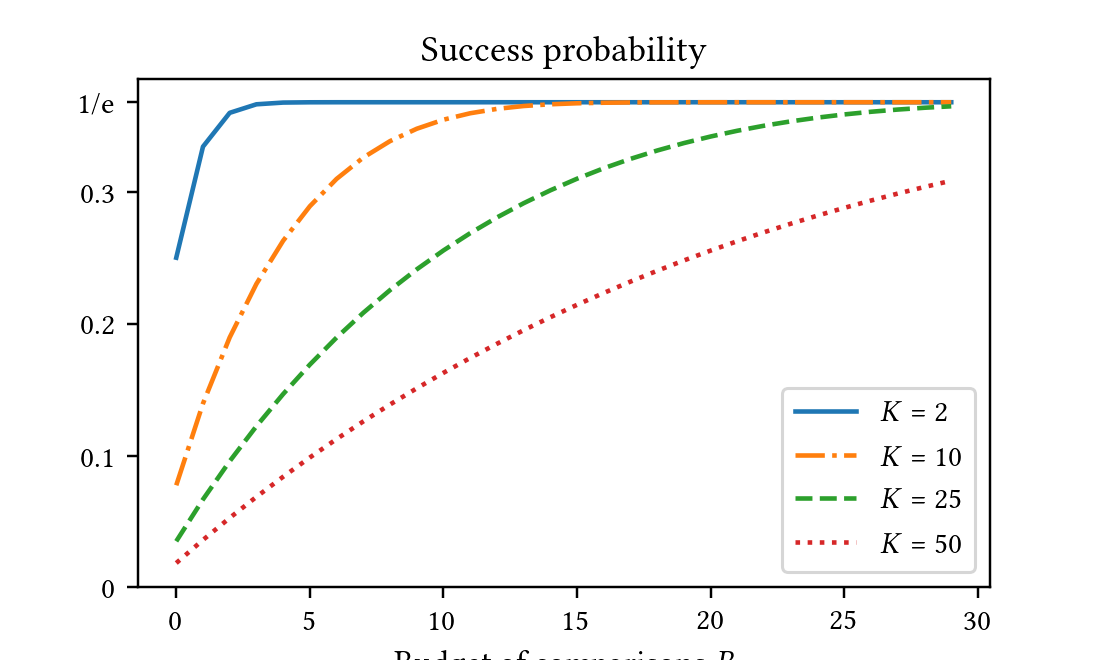

In [65]:
Kvals = [2,10,25,50]
Bvals = np.arange(30)

linestyle = ["-","-.","--",":"]
proba = np.zeros((len(Kvals), len(Bvals)))
thresh = np.zeros((len(Kvals), len(Bvals)))

for i in range(len(Kvals)):
    K = Kvals[i]
    for j in range(len(Bvals)):
        B = Bvals[j]
        thresh[i,j],proba[i,j] = getBestST(K,B)

figure(figsize=(5,3))
for i in range(len(Kvals)):
    plt.plot(Bvals,proba[i],linestyle[i], label = r"$K$ = " + str(Kvals[i]) )

yvals = [0,0.1,0.2,0.3,1/e]
ylabels = ["0","0.1","0.2","0.3","1/e"]
plt.yticks(yvals, ylabels)

plt.xlabel(r"Budget of comparisons $B$", fontsize=11)
plt.legend()
plt.title("Success probability")
plt.savefig('STproba_KvsB.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


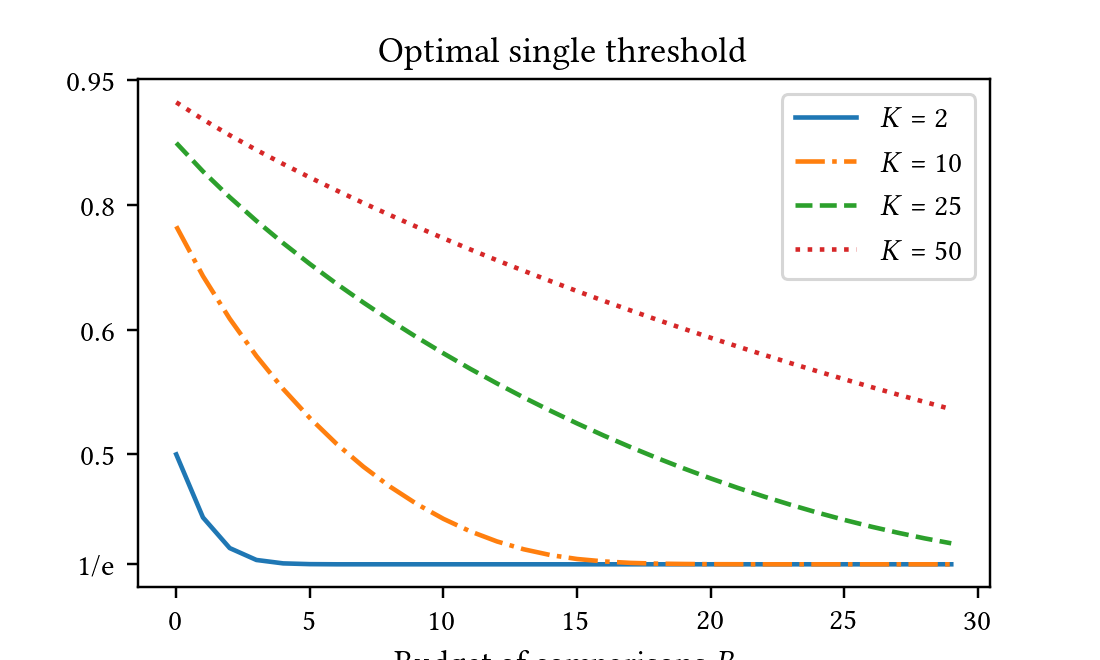

In [66]:
figure(figsize=(5,3))
for i in range(len(Kvals)):
    plt.plot(Bvals,thresh[i],linestyle[i], label = r"$K$ = " + str(Kvals[i]) )

yvals = [1/e, 0.5,0.65,0.8,0.95]
ylabels = ["1/e","0.5","0.6","0.8","0.95"]
plt.yticks(yvals, ylabels)

plt.xlabel(r"Budget of comparisons $B$", fontsize=11)
plt.legend()
plt.title("Optimal single threshold")
plt.savefig('STthresh_KvsB.pdf', bbox_inches='tight')

# Implementing the algorithm

In [206]:
# Special case: classical secretary
def secretary(x,w):
    maxOverall = 0
    N = len(x)
    for t in range(len(x)):
        if t/N > w and x[t] > maxOverall:
            return t
        maxOverall = max(maxOverall, x[t])
    return -1

def testSecretary(N,w=1/e,niters=1000):
    countSuccess = 0
    for i in range(niters):
        x = np.random.rand(N)
        selected = secretary(x,w)
        countSuccess += int(selected == x.argmax())
    return countSuccess/niters

In [207]:
def candidateGroup(lmb):
    v = np.random.rand()
    #print("v = ",v)
    s = lmb[0]
    for g in range(1,len(lmb)):
        #print("s = ",s)
        if s > v:
            return g-1
        s += lmb[g]
    return len(lmb)-1

def singleThresh(x,B,lmb,w):
    # lmb is of size K
    K = len(lmb)
    N = len(x)
    maxG = {k: 0 for k in range(K)}
    maxOverall = 0
    for t in range(len(x)):
        # New observation --------------------------------------
        gt = candidateGroup(lmb)
        rt = int(x[t] > maxG[gt])
        # Action -----------------------------------------------
        if rt == 1:
            maxG[gt] = x[t]
            if B==0 and t/N > w:
                return t
            elif B>0 and t/N > w:
                # make a comparison
                B = B-1
                Rt = int(x[t] > maxOverall)
                if Rt == 1:
                    return t
        maxOverall = max(maxOverall, x[t])
    return -1

In [208]:
def testSingleThresh(N,B,lmb,w=1/e,niters=1000):
    countSuccess = 0
    for i in range(niters):
        x = np.random.rand(N)
        selected = singleThresh(x,B,lmb,w)
        countSuccess += int(selected == x.argmax())
    return countSuccess/niters

# Success proba independent of $\lambda$

In [ ]:
N = 500
Bmax = 2
m = 50
niters = 100000

#lmb1vals = np.linspace(0,1,m)
lmbVals = np.arange(6)/100
proba = np.zeros((Bmax+1,len(lmb1vals)))

ti = time()
for i in range(len(lmbVals)):
    print("i = ",i,", time = ",time()-ti)
    for B in range(Bmax+1):
        lmb = [lmb1vals[i], 1-lmb1vals[i]]
        wB = getBestST(2,B)[0]
        proba[B,i] = testSingleThresh(N,B,lmb, w=wB, niters=niters)
print("time = ", time()-ti)

<IPython.core.display.Javascript object>


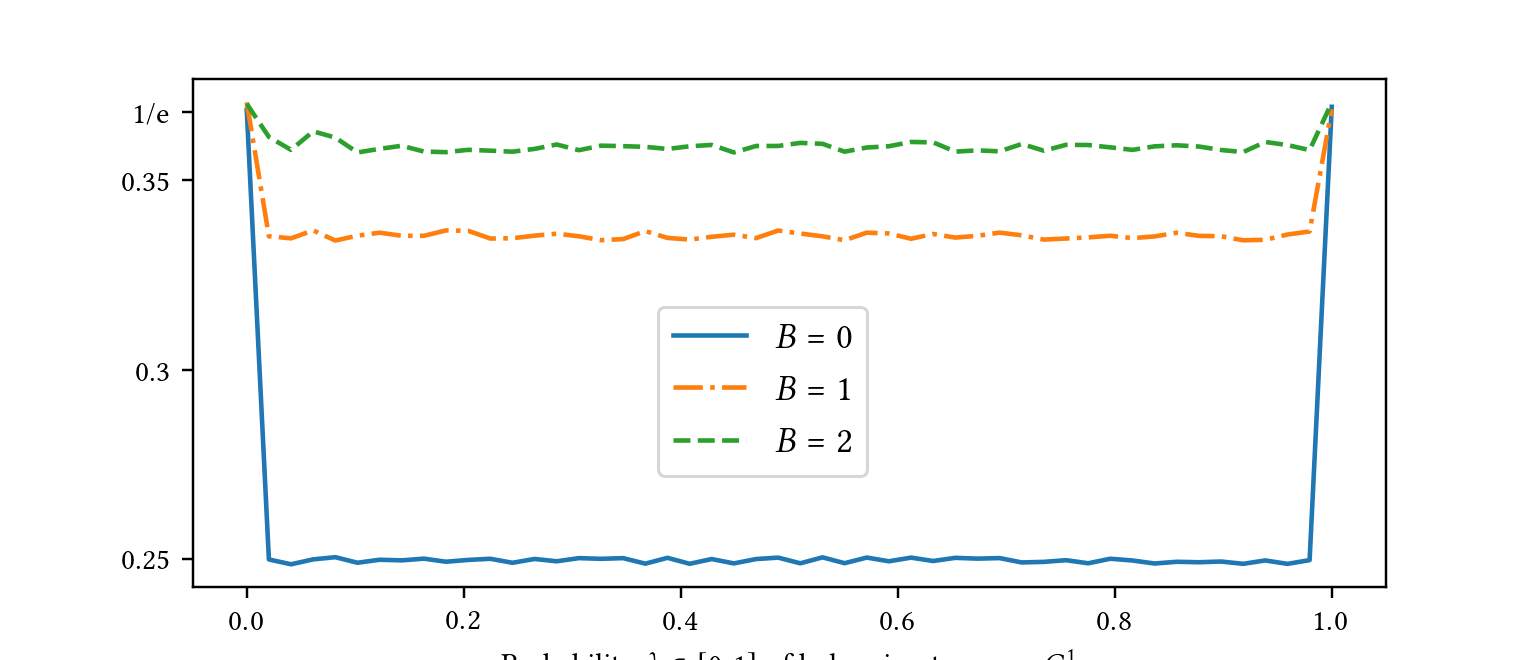

In [534]:
figure(figsize=(7,3))
linestyle = ["-","-.","--",":"]
lmb1vals = np.linspace(0,1,len(proba[0]))

for B in range(Bmax+1):
    plt.plot(lmb1vals,proba[B], linestyle[B], label=r"$B$ = " + str(B))
plt.legend(fontsize=12, loc=(0.39,0.22))
yvals = [0.25,0.3,0.35,1/e]
ylabels = ["0.25","0.3","0.35","1/e"]
plt.yticks(yvals, ylabels)
plt.xlabel(r"Probability $\lambda\in [0,1]$ of belonging to group $G^1$")
plt.savefig('ST_lmb_discontinuity.pdf', bbox_inches='tight')